# Model building for Hirotec

#### Neccassary Imports

In [25]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
from IPython.display import display, Image
from PIL import Image
import os
from PIL import ImageDraw

Ultralytics YOLOv8.0.196  Python-3.9.18 torch-1.7.1+cu110 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Setup complete  (12 CPUs, 7.7 GB RAM, 220.0/260.6 GB disk)


In [ ]:
# !mkdir {HOME}/datasets_aug
# %cd {HOME}/datasets_aug

# !pip install roboflow --quiet

# from roboflow import Roboflow
# rf = Roboflow(api_key="UQ9uhP8Jvq8Fa494PmNY")
# project = rf.workspace("test-ijcnp").project("test_bonnet")
# dataset = project.version(2).download("yolov8")

# Training 

In [2]:
# %cd {HOME}
# !yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=25 imgsz=800 plots=True
!yolo task=segment mode=train model=yolov8s-seg.pt data="C:\Users\krsou\Downloads\Hirotec\hirotec_dataset\msil_seg\dataset.yaml" epochs=3 imgsz=768 

^C


# Prediction

In [3]:
# %cd {HOME}
!yolo task=segment mode=predict model="weights/trained_with_65_BS2/content/runs/segment/train/weights/best.pt" conf=0.1 source="enache.png" save=true show_labels=True boxes=False

Ultralytics YOLOv8.0.196  Python-3.9.18 torch-1.7.1+cu110 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs

image 1/1 c:\Users\krsou\Downloads\Hirotec\enache.png: 480x800 1 Black_Sealant, 65.3ms
Speed: 15.0ms preprocess, 65.3ms inference, 99.9ms postprocess per image at shape (1, 3, 480, 800)
Results saved to runs\segment\predict3
 Learn more at https://docs.ultralytics.com/modes/predict


# Code wise prediction and Saving the Images

#### Load Model

In [4]:


# yolo_without_aug_model = YOLO("C:/Users/krsou/Downloads/Hirotec/weights/yolov8/content/runs/segment/train2/weights/best.pt")
# yolo_with_aug_model = YOLO("weights/yolov8_trained_with_augmented_seg_img_size_640/weights/best.pt")
# yolo_trained_with_65_images = YOLO("weights/train13/weights/best.pt")
yolo_trained_with_65_BS = YOLO("C:/Users/krsou/Downloads/Hirotec/weights/trained_with_65_BS2/content/runs/segment/train/weights/best.pt")

#### This will predict and save the masked images inside a folder. (Manage Paths accordingly)

In [39]:
# os.chdir("C:/Users/krsou/Downloads/Hirotec/hirotec_dataset/black_sealant_seg_2/images/test")
os.chdir("C:/Users/krsou/Downloads/Hirotec/hirotec_dataset/enhanced")
dataset_dir = os.getcwd()
print(dataset_dir)

for img in os.listdir(dataset_dir):
    if img.split(".")[1] == "png":
        # print(img.shape)
        results = yolo_trained_with_65_BS(img,imgsz=768)
        result = results[0]
        masks = result.masks
        print(len(masks))
        mask1 = masks[0]
        mask = masks.cpu().data[0].numpy()
        polygon = mask1.cpu().xy[0]
        mask_img = Image.fromarray(mask,"I")
        image = mask_img.convert("L")
        # os.chdir("C:/Users/krsou/Downloads/Hirotec/hirotec_results")
        mask_img
        mask_image_name = img.split(".")[0]+"_mask."+img.split(".")[1]
        print(mask_image_name)
        # image.save("/hirotec_results/{img}".format(img=saving_name))
        Inspected_image_folder = "C:/Users/krsou/Downloads/Hirotec/hirotec_results/Inspection4_enhanced"
        image.save(f"{Inspected_image_folder}/{mask_image_name}")

        predict_image_name = img.split(".")[0]+"_prediction."+img.split(".")[1]
        img_pred = Image.open(img)
        draw = ImageDraw.Draw(img_pred)
        draw.polygon(polygon,outline=(0,255,0), width=2)
        img_pred.save(f"{Inspected_image_folder}/{predict_image_name}")


C:\Users\krsou\Downloads\Hirotec\hirotec_dataset\enhanced


image 1/1 C:\Users\krsou\Downloads\Hirotec\hirotec_dataset\enhanced\enache_image.png: 448x768 1 Black_Sealant, 407.2ms
Speed: 614.0ms preprocess, 407.2ms inference, 9.1ms postprocess per image at shape (1, 3, 448, 768)


1
enache_image_mask.png


In [8]:


# result = results[0]
# masks = result.masks
# print(len(masks))
# mask1 = masks[0]
# mask = masks.cpu().data[0].numpy()
# polygon = mask1.cpu().xy[0]
# mask_img = Image.fromarray(mask,"I")
# image = mask_img.convert("L")
# os.chdir("C:/Users/krsou/Downloads/Hirotec/hirotec_results")
# mask_img
# image.save("masked_img_new.jpg")

1


In [116]:


# cv2.imwrite('masked_image.png',mask_img)



In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/segment/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

### Enhancing the Image

In [31]:
from PIL import Image, ImageEnhance
import numpy as np
import cv2

def get_gan_image(upsampler,img,pts):
    cv2.imwrite('enache_image.png',img)
    output, _ = upsampler.enhance(img, outscale=4)
    output = Image.fromarray(output)
    contrast = 1.5
    output = ImageEnhance.Contrast(output).enhance(contrast)
    brightness = 1.2
    output = ImageEnhance.Brightness(output).enhance(brightness)
    output = np.asarray(output)
    output = cv2.resize(output,(1280,960))
    return output

In [32]:
import sys
sys.path.insert(0,"C:/Users/krsou/Downloads/Hirotec/LINCODE_AI_WORKER/LINCODE_AI_WORKER/GAN")
from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact 
from basicsr.archs.rrdbnet_arch import RRDBNet

def load_gan_model(weights):
    model = SRVGGNetCompact(num_in_ch=3, num_out_ch=3, num_feat=64, num_conv=16, upscale=4, act_type='prelu')
    netscale = 4
    upsampler = RealESRGANer(scale=netscale,model_path=weights,dni_weight=None,model=model,tile=0,tile_pad=10,pre_pad=0,half=True,gpu_id=0)   
    print('GAN "Model loaded! and is done!!"')             
    return upsampler

In [33]:
import cv2
gan_weight = "C:/Users/krsou/Downloads/Hirotec/weights/realesr-animevideov3.pth"
gan_frame = cv2.imread("C:/Users/krsou/Downloads/Hirotec/hirotec_dataset/black_sealant_seg_2/images/train/image_1.png")
upsampler  = load_gan_model(weights = gan_weight)

GAN "Model loaded! and is done!!"


In [34]:
def gan_output():
    predicted_frame = get_gan_image(upsampler,img = gan_frame, pts = None)
    return predicted_frame 

In [35]:
enhanced_frame = gan_output()

# Gausian Blur image enhancement

#

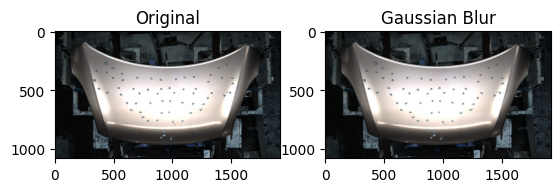

In [41]:
#Import the necessary libraries 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 

# Load the image 
image = cv2.imread('C:/Users/krsou/Downloads/Hirotec/hirotec_dataset/enhanced/Original_Image/image_1.png') 

#Plot the original image 
plt.subplot(1, 2, 1) 
plt.title("Original") 
plt.imshow(image) 

# Remove noise using a Gaussian filter 
filtered_image2 = cv2.GaussianBlur(image, (7, 7), 0) 

#Save the image 
cv2.imwrite('Gaussian Blur.jpg', filtered_image2) 

#Plot the blured image 
plt.subplot(1, 2, 2) 
plt.title("Gaussian Blur") 
plt.imshow(filtered_image2) 
plt.show()
